In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
from IPython.display import display

import glob
import sys
import joblib

sys.path.insert(-1,'../Tools')
from data_parser_new import parse
from data_analysis import split_vcg_vector, df_vcg_vector, plot_vcgs, calc_cost, calc_cost_wrong, calc_cost_rms, calc_cost_rms_norm
from data_modification import trim_tat_patient, resample_patient

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

# Load Data

In [2]:
data_path = '../Data/'
patients = [
            parse(initial_path=data_path, patient_number=patient_no, at_map = True, verbose = False) 
        #for patient_no in [0]
        for patient_no in range(0,8)
]

In [3]:
# Rescale in time
num_samples = 100
patients = [trim_tat_patient(patient) for patient in patients]
patients = [resample_patient(patient,length=num_samples) for patient in patients]

In [4]:
# Concatinate data
for patient in patients:
    vcg_list = [pd.concat([x['VCGx'],x['VCGy'],x['VCGz']],axis=0,ignore_index=True).to_frame(name='VCG_%i'%(i+1)) for i,x in enumerate(patient['vcg_model']) if isinstance(x, pd.core.frame.DataFrame)]
    patient['vcg_df'] = pd.concat([x for x in vcg_list],axis=1)

all_vcg = pd.concat([patient['vcg_df'].add_prefix(patient['pt_id']+'_') for patient in patients],axis=1)
all_vcg.head()

,BiV7_VCG_1,BiV7_VCG_2,BiV7_VCG_3,BiV7_VCG_4,BiV7_VCG_5,BiV7_VCG_6,BiV7_VCG_7,BiV7_VCG_8,BiV7_VCG_9,BiV7_VCG_10,...,BiV5_VCG_172,BiV5_VCG_173,BiV5_VCG_174,BiV5_VCG_175,BiV5_VCG_176,BiV5_VCG_177,BiV5_VCG_178,BiV5_VCG_179,BiV5_VCG_180,BiV5_VCG_181
0,-4.885451e-07,-4.885451e-07,-4.885451e-07,-4.885451e-07,-4.885451e-07,-4.885451e-07,-4.885451e-07,-4.885451e-07,-4.885451e-07,-4.885451e-07,...,-0.000767,-0.005216,-0.001929,-0.002877,-0.000734,-0.004325,0.001004,0.001357,-0.000772,-0.001607
1,6.622048e-03,4.537618e-03,6.316384e-03,3.975784e-02,1.046922e-02,8.247684e-03,2.334715e-02,5.680797e-03,4.565219e-03,3.832291e-03,...,0.000136,0.013300,0.009794,0.013297,0.017550,0.009536,-0.004358,0.014715,0.002138,0.006865
2,-3.119428e-04,-3.661225e-03,6.638612e-03,1.604343e-01,4.564471e-03,3.779841e-02,8.912764e-02,1.122397e-02,9.405159e-03,8.619270e-03,...,0.014707,0.027232,0.008629,0.054125,0.064210,0.018015,-0.048013,0.048932,0.024568,0.026856
3,-2.024833e-03,4.625847e-03,2.006426e-02,3.145304e-01,3.781926e-02,7.495631e-02,1.343772e-01,3.417597e-02,2.894058e-02,2.599079e-02,...,0.032834,0.027968,-0.035330,0.146256,0.111832,0.050509,-0.143785,0.049443,0.045022,0.067675
4,-3.335238e-02,-6.543593e-04,2.263358e-02,4.820751e-01,4.246096e-02,1.101693e-01,2.044899e-01,3.381935e-02,4.197545e-02,3.670570e-02,...,0.040714,-0.014634,-0.053163,0.283752,0.151603,0.083270,-0.125129,0.016351,0.063878,0.145466


In [5]:
print(all_vcg.shape)
failed = all_vcg.columns[~all_vcg.any()]
print(failed)
all_at = all_vcg.drop(failed,axis=1,)
print(all_vcg.shape)
X_train = all_vcg.to_numpy().transpose()
print(X_train.shape)

(300, 1420)
Index([], dtype='object')
(300, 1420)
(1420, 300)


In [6]:
# Run PCA
pca = PCA(n_components=20)
pca.fit(X_train) # fit trains the PCA
eigvals = pca.singular_values_
components = np.array(pca.components_)

ncomp = components.shape[0]
nfeat = components.shape[1]
print('Number of features: %d' %nfeat)
print('Number of components: %d' %ncomp)
print('Component matrix shape: (%d,%d)' %(ncomp,nfeat))

Number of features: 300
Number of components: 20
Component matrix shape: (20,300)


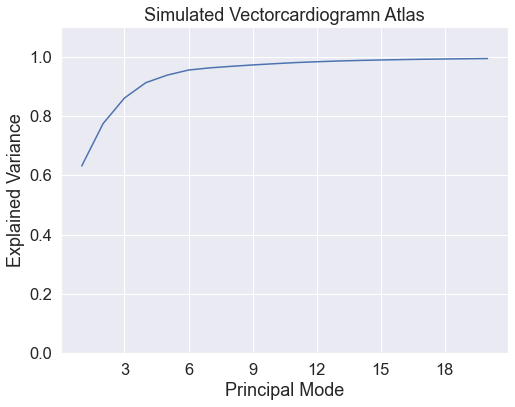

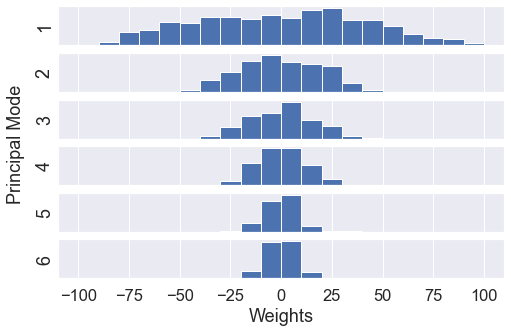

In [7]:
# Explained variance
sns.set(font_scale=1.5)
X_variance = np.cumsum(pca.explained_variance_ratio_)
component_number = np.arange(len(X_variance)) + 1

plt.figure(1,figsize=(8,6))
axes = plt.figure(1).gca()
axes.plot(component_number, X_variance)
axes.xaxis.set_major_locator(MaxNLocator(integer=True))
axes.set(ylim=(0,1.1), 
            xlabel="Principal Mode", 
            ylabel="Explained Variance",
            title="Simulated Vectorcardiogramn Atlas");

# Component weights
X_weights = pca.transform(X_train)
nplots = ncomp
nplots = 6
fig, axes = plt.subplots(nplots, 1, figsize=(8,np.min([ncomp,5])), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(X_weights[:,i], 20, (-100,100)) # default: 10, (-20,20)
    ax.set_ylabel(i+1)
    ax.set_yticks([])
plt.xlabel('Weights');
plt.text(-135,1300,'Principal Mode', rotation='vertical');

In [8]:
pca.explained_variance_ratio_[0:5]

array([0.63188941, 0.14282645, 0.08623692, 0.05173306, 0.02544077])

In [9]:
X_variance[9]

0.9765327890010441

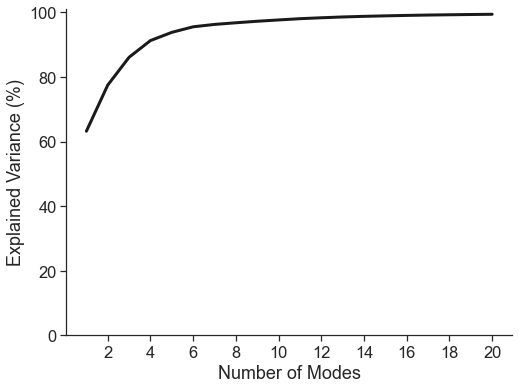

In [10]:
sns.set_style("ticks")

plt.figure(1,figsize=(8,6))
axes = plt.figure(1).gca()
axes.plot(component_number, X_variance*100, 'k',linewidth = 3)
axes.xaxis.set_major_locator(MaxNLocator(integer=True))
axes.xaxis.set_major_locator(ticker.MultipleLocator(2))
axes.set(ylim=(0,101),
            xlabel="Number of Modes", 
            ylabel="Explained Variance (%)");

sns.despine()
plt.savefig('Fig2A.pdf', transparent=True)

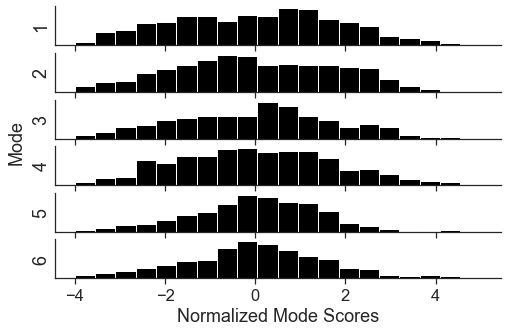

In [11]:
X_weights = pca.transform(X_train)
nplots = ncomp
nplots = 6

# normalize
for i in range(nplots):
    X_weights[:,i] = X_weights[:,i]/(np.absolute(X_weights[:,i]).std())


fig, axes = plt.subplots(nplots, 1, figsize=(8,np.min([ncomp,5])), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(X_weights[:,i], 20, (-4,5),color = "black") # default: 10, (-20,20)
    ax.set_ylabel(i+1)
    ax.set_yticks([])
plt.xlabel('Normalized Mode Scores');
plt.text(-5.5,600,'Mode', rotation='vertical');
sns.despine()
plt.savefig('Fig2C.pdf', transparent=True)

# Save off atlas

In [13]:
fname = 'VCG_atlas_all.pickle'
#joblib.dump(pca,fname)

fname = 'VCG_atlas_all_weights.pickle'
#joblib.dump(X_weights,fname)

# Calculate and visualize atlas mean

In [14]:
# Using percentiles of a sample population
X_weights = pca.transform(X_train)
print('Shape of X_train weights: (%d,%d)' %(X_weights.shape[0],X_weights.shape[1]))

mean = pca.mean_
df_mean = df_vcg_vector(mean)

Shape of X_train weights: (1420,20)


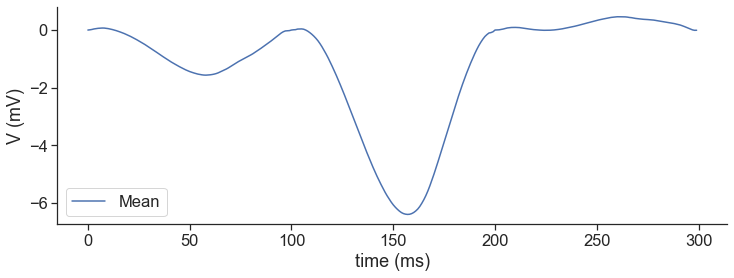

In [15]:
with sns.axes_style('ticks'):
    plt.figure(2, figsize=(12,4))
    plt.plot(mean)
    #plt.plot(recon5th)
    #plt.plot(recon95th)
    plt.xlabel('time (ms)')
    plt.ylabel('V (mV)')
    plt.legend(['Mean',
    #            'Component '+np.str(compNum)+', 5th percentile',
    #            'Component '+np.str(compNum)+', 95th percentile'
               ]);
    sns.despine()

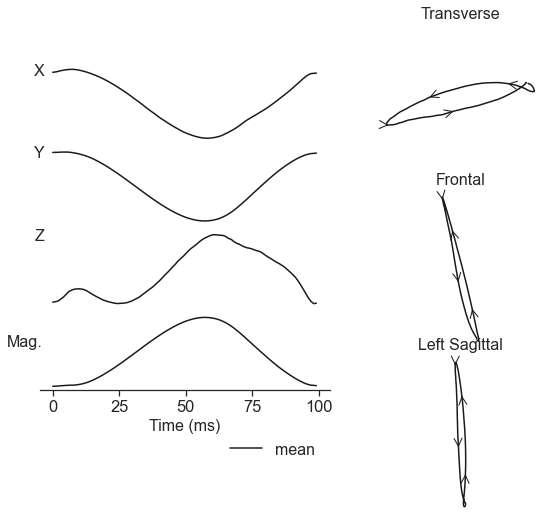

In [16]:
plot_vcgs(['mean','mean2','mean3'],df_mean,ref_lines=False,arrows=True)

# Visualize First mode

In [17]:
# extract 5th percentile
mode = 0
p = 5.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m1p5 = pca.mean_ + np.dot(w,components[comps])
df_m1p5 = df_vcg_vector(m1p5[0])

In [18]:
# extract 95th percentile
mode = 0
p = 95.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m1p95 = pca.mean_ + np.dot(w,components[comps])
df_m1p95 = df_vcg_vector(m1p95[0])

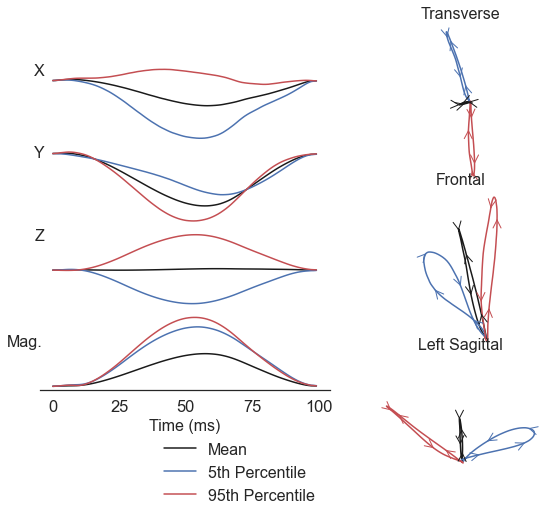

In [59]:
plot_vcgs(['Mean','5th Percentile','95th Percentile'],df_mean,df_m1p5,df_m1p95,ref_lines=False,arrows=True)
plt.savefig('Fig2B-legend.pdf', transparent=True)

## Mode 2

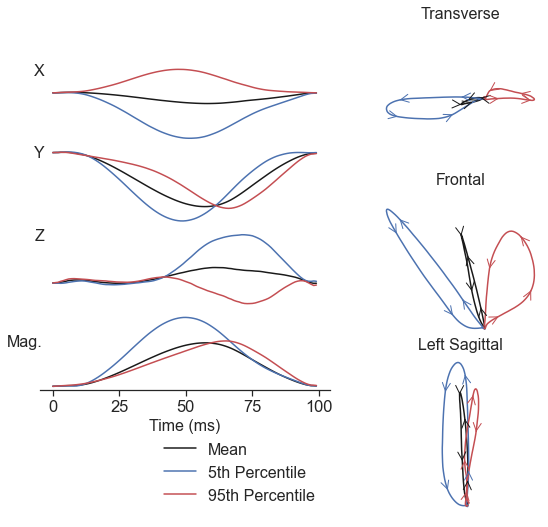

In [20]:
# extract 5th percentile
mode = 1
p = 5.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m2p5 = pca.mean_ + np.dot(w,components[comps])
df_m2p5 = df_vcg_vector(m2p5[0])

# extract 95th percentile
p = 95.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m2p95 = pca.mean_ + np.dot(w,components[comps])
df_m2p95 = df_vcg_vector(m2p95[0])

plot_vcgs(['Mean','5th Percentile','95th Percentile'],df_mean,df_m2p5,df_m2p95,ref_lines=False,arrows=True)

## Mode 3

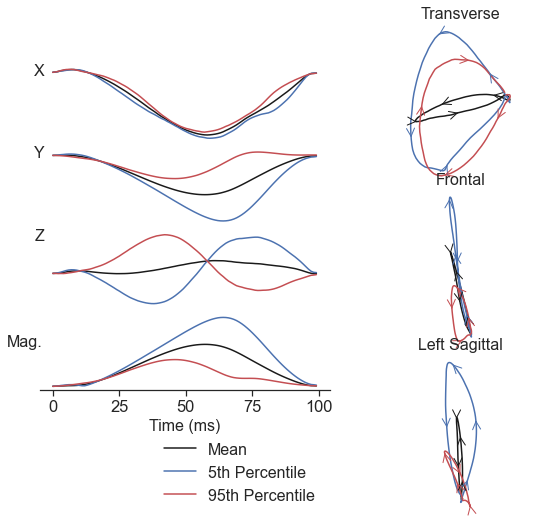

In [21]:
# extract 5th percentile
mode = 2
p = 5.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m3p5 = pca.mean_ + np.dot(w,components[comps])
df_m3p5 = df_vcg_vector(m3p5[0])

# extract 95th percentile
p = 95.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m3p95 = pca.mean_ + np.dot(w,components[comps])
df_m3p95 = df_vcg_vector(m3p95[0])

plot_vcgs(['Mean','5th Percentile','95th Percentile'],df_mean,df_m3p5,df_m3p95,ref_lines=False,arrows=True)

## Mode 4

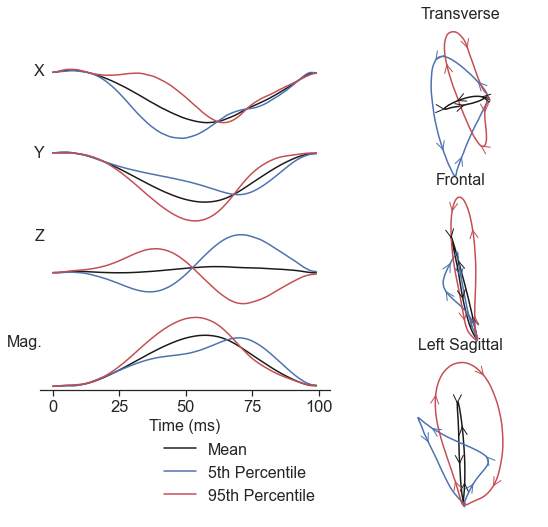

In [22]:
# extract 5th percentile
mode = 3
p = 5.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m4p5 = pca.mean_ + np.dot(w,components[comps])
df_m4p5 = df_vcg_vector(m4p5[0])

# extract 95th percentile
p = 95.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m4p5 = pca.mean_ + np.dot(w,components[comps])
df_m4p95 = df_vcg_vector(m4p5[0])

plot_vcgs(['Mean','5th Percentile','95th Percentile'],df_mean,df_m4p5,df_m4p95,ref_lines=False,arrows=True)

## Mode 5

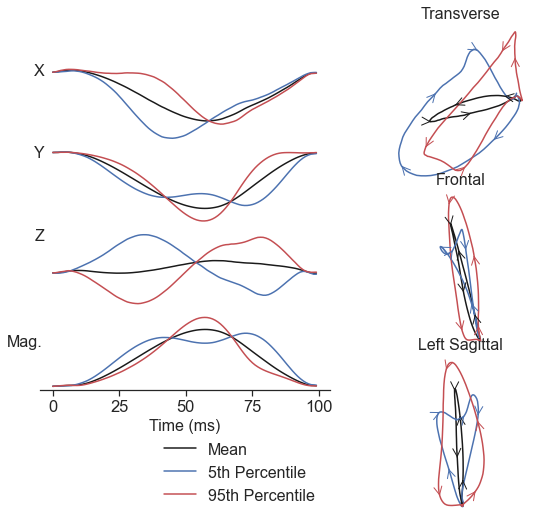

In [23]:
# extract 5th percentile
mode = 4
p = 5.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m5p5 = pca.mean_ + np.dot(w,components[comps])
df_m5p5 = df_vcg_vector(m5p5[0])

# extract 95th percentile
p = 95.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m5p5 = pca.mean_ + np.dot(w,components[comps])
df_m5p95 = df_vcg_vector(m5p5[0])

plot_vcgs(['Mean','5th Percentile','95th Percentile'],df_mean,df_m5p5,df_m5p95,ref_lines=False,arrows=True)

## Mode 6

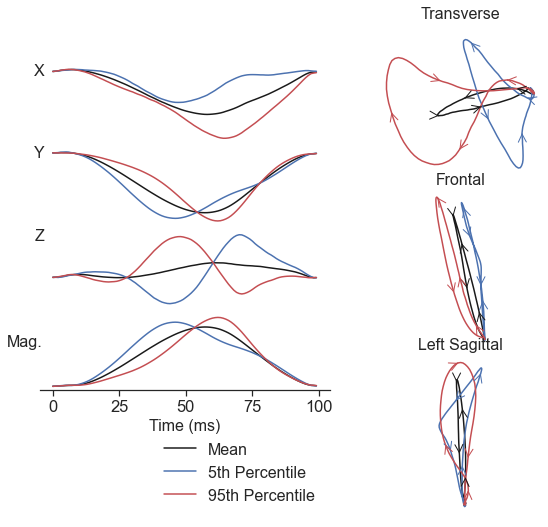

In [24]:
# extract 5th percentile
mode = 5
p = 5.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m6p5 = pca.mean_ + np.dot(w,components[comps])
df_m6p5 = df_vcg_vector(m6p5[0])

# extract 95th percentile
p = 95.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m6p5 = pca.mean_ + np.dot(w,components[comps])
df_m6p95 = df_vcg_vector(m6p5[0])

plot_vcgs(['Mean','5th Percentile','95th Percentile'],df_mean,df_m6p5,df_m6p95,ref_lines=False,arrows=True)

## Mode 7

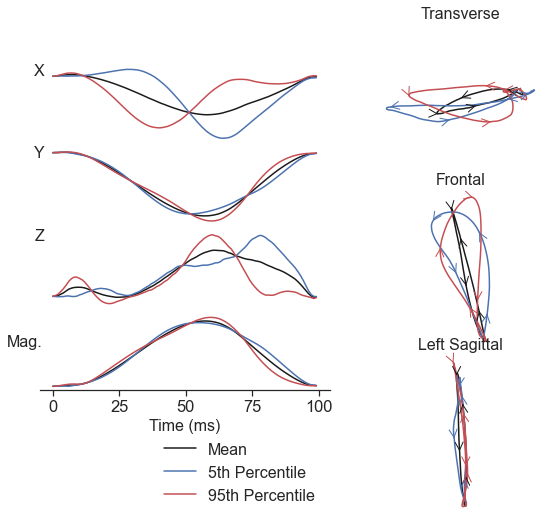

In [25]:
# extract 5th percentile
mode = 6
p = 5.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m7p5 = pca.mean_ + np.dot(w,components[comps])
df_m7p5 = df_vcg_vector(m7p5[0])

# extract 95th percentile
p = 95.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m7p5 = pca.mean_ + np.dot(w,components[comps])
df_m7p95 = df_vcg_vector(m7p5[0])

plot_vcgs(['Mean','5th Percentile','95th Percentile'],df_mean,df_m7p5,df_m7p95,ref_lines=False,arrows=True)

## Mode 8

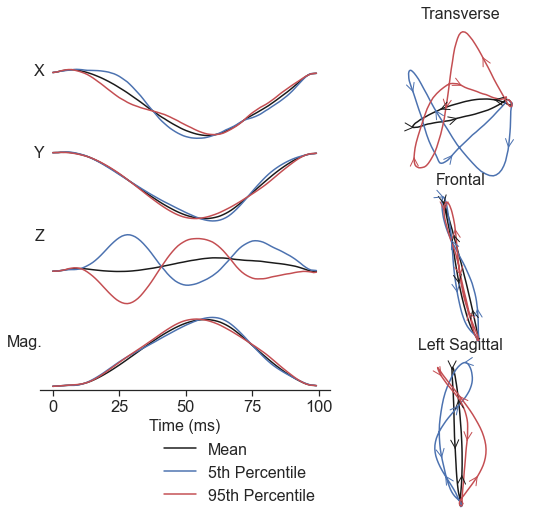

In [26]:
# extract 5th percentile
mode = 7
p = 5.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m8p5 = pca.mean_ + np.dot(w,components[comps])
df_m8p5 = df_vcg_vector(m8p5[0])

# extract 95th percentile
p = 95.0
comps =[mode]
w = np.percentile(X_weights[:,mode],p)
m8p5 = pca.mean_ + np.dot(w,components[comps])
df_m8p95 = df_vcg_vector(m8p5[0])

plot_vcgs(['Mean','5th Percentile','95th Percentile'],df_mean,df_m8p5,df_m8p95,ref_lines=False,arrows=True)

In [27]:
def plot_vcgs_horizontal(labels, vcg1, vcg2=None, vcg3=None, ref_lines=False, alt_lines=False):

    # sns.reset_orig()
    sns.set_style('white')
    fig = plt.figure(figsize=(18, 3))
    fig.patch.set_facecolor('white')
    ax1 = plt.subplot2grid((3, 18), (0, 0), colspan=6, rowspan=3)
    ax2 = plt.subplot2grid((3, 18), (0, 6), colspan=6, rowspan=3)
    ax3 = plt.subplot2grid((3, 18), (0, 12), colspan=6, rowspan=3)

    t = np.arange(len(vcg1['VCGx']))

    ax1.plot(t, vcg1['VCGx'], 'k-',linewidth='2.5')
    if ref_lines: ax1.axhline(y=0.0, xmin=0.0, xmax=1.0, color='0.5', linewidth='1.5')
    ax1.axis('off')
    ax1.set_xlim([0, 100])
    ax1.set_ylim([-12, 12])

    ax2.plot(t, vcg1['VCGy'], 'k-',linewidth='2.5')
    if ref_lines: ax2.axhline(y=0.0, xmin=0.0, xmax=1.0, color='0.5', linewidth='1.5')
    ax2.axis('off')
    ax2.set_xlim([0, 100])
    ax2.set_ylim([-12, 12])

    ax3.plot(t, vcg1['VCGz'], 'k-',linewidth='2.5')
    if ref_lines: ax3.axhline(y=0.0, xmin=0.0, xmax=1.0, color='0.5', linewidth='1.5')
    ax3.axis('off')
    ax3.set_xlim([0, 100])
    ax3.set_ylim([-12, 12])
    
    if alt_lines:
        line_style = alt_lines
    else:
        line_style = ['b-','r-']

    if isinstance(vcg2, pd.DataFrame):
        t_vcg = np.arange(len(vcg2['VCGx']))
        ax1.plot(t_vcg, vcg2['VCGx'], line_style[0],linewidth='2.5')
        ax2.plot(t_vcg, vcg2['VCGy'], line_style[0],linewidth='2.5')
        ax3.plot(t_vcg, vcg2['VCGz'], line_style[0],linewidth='2.5')
    if isinstance(vcg3, pd.DataFrame):
        t_vcg = np.arange(len(vcg3['VCGx']))
        ax1.plot(t_vcg, vcg3['VCGx'], line_style[1],linewidth='2.5')
        ax2.plot(t_vcg, vcg3['VCGy'], line_style[1],linewidth='2.5')
        ax3.plot(t_vcg, vcg3['VCGz'], line_style[1],linewidth='2.5')

Mode 1


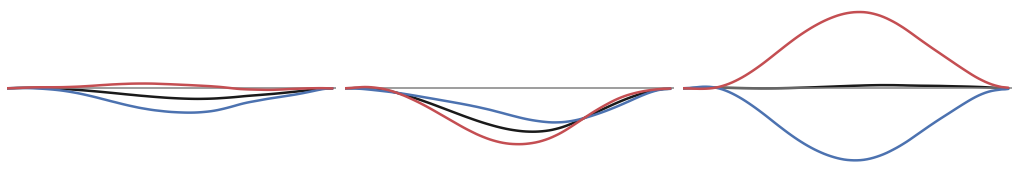

In [28]:
plot_vcgs_horizontal(['Mean','5th Percentile','95th Percentile'],df_mean,df_m1p5,df_m1p95,ref_lines=True)
print('Mode 1')
plt.savefig('Fig2B-1.pdf', transparent=True)

Mode 2


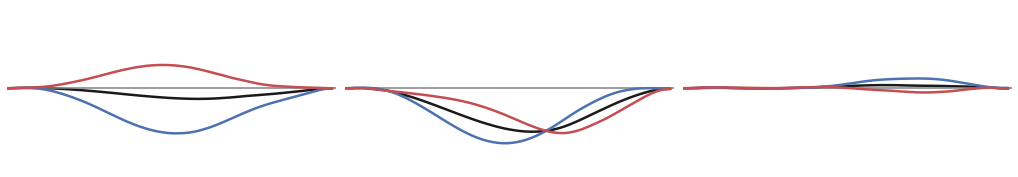

In [29]:
plot_vcgs_horizontal(['Mean','5th Percentile','95th Percentile'],df_mean,df_m2p5,df_m2p95,ref_lines=True)
print('Mode 2')
plt.savefig('Fig2B-2.pdf', transparent=True)

Mode 3


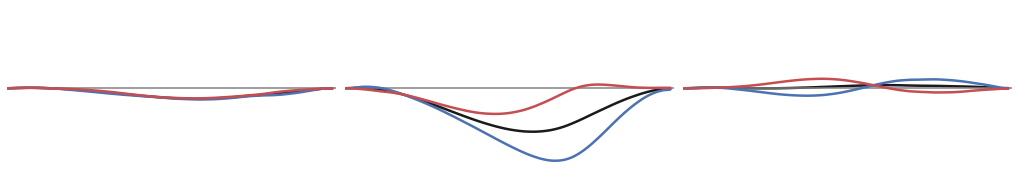

In [30]:
plot_vcgs_horizontal(['Mean','5th Percentile','95th Percentile'],df_mean,df_m3p5,df_m3p95,ref_lines=True)
print('Mode 3')
plt.savefig('Fig2B-3.pdf', transparent=True)

Mode 4


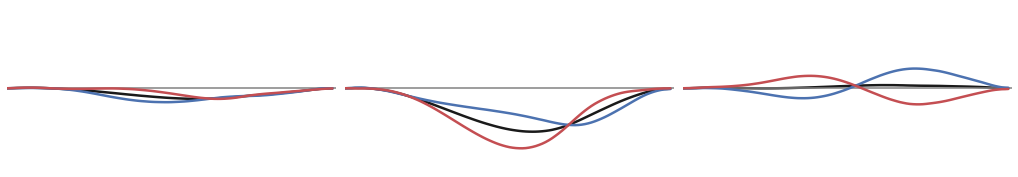

In [31]:
plot_vcgs_horizontal(['Mean','5th Percentile','95th Percentile'],df_mean,df_m4p5,df_m4p95,ref_lines=True)
print('Mode 4')
plt.savefig('Fig2B-4.pdf', transparent=True)

Mode 5


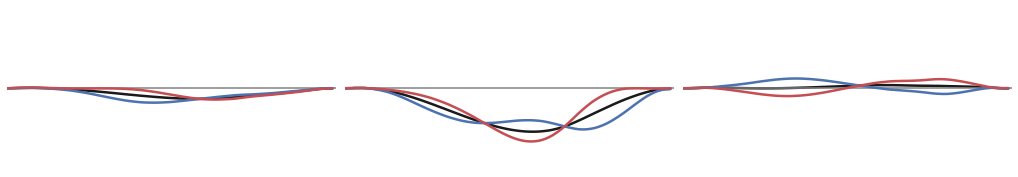

In [32]:
plot_vcgs_horizontal(['Mean','5th Percentile','95th Percentile'],df_mean,df_m5p5,df_m5p95,ref_lines=True)
print('Mode 5')
plt.savefig('Fig2B-5.pdf', transparent=True)

Mode 6


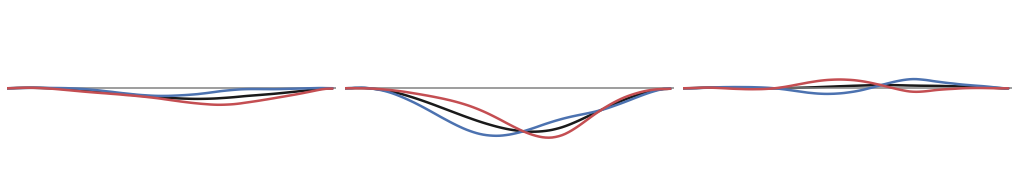

In [33]:
plot_vcgs_horizontal(['Mean','5th Percentile','95th Percentile'],df_mean,df_m6p5,df_m6p95,ref_lines=True)
print('Mode 6')
plt.savefig('Fig2B-6.pdf', transparent=True)

# Calculate and Visualize Mode Sensitivity Objective Function

I will use three methods to calculate the objective function
1. Theta (modified from Villongco et al. 2014)
1. RMS Error
1. Normalized RMS Error

There is also a detour exploring what was wrong with the original Theta objective function from 2014

In [34]:
range_modes = np.linspace(5,95,7,endpoint=True)
range_modes

array([ 5., 20., 35., 50., 65., 80., 95.])

In [35]:
n_modes = 6
range_modes = np.linspace(5,95,7,endpoint=True)
print(range_modes)

mode_theta = np.zeros([n_modes,len(range_modes)])
mode_theta_wrong = np.zeros([n_modes,len(range_modes)])
mode_rms = np.zeros([n_modes,len(range_modes)])
mode_rmsx = np.zeros([n_modes,len(range_modes)])
mode_rmsy = np.zeros([n_modes,len(range_modes)])
mode_rmsz = np.zeros([n_modes,len(range_modes)])
mode_rms_norm = np.zeros([n_modes,len(range_modes)])

# loop through and calculate objective function for all modes
for n in np.arange(n_modes):
    for i,m in enumerate(range_modes):
        comps =[n]
        w = np.percentile(X_weights[:,n],m)
        recon_VCG = pca.mean_ + np.dot(w,components[comps])
        df_recon_VCG = df_vcg_vector(recon_VCG[0])
        
        mode_theta[n,i] = calc_cost(df_mean,df_recon_VCG)
        mode_theta_wrong[n,i] = calc_cost_wrong(df_mean,df_recon_VCG)
        mode_rms[n,i] = calc_cost_rms(df_mean,df_recon_VCG)
        mode_rmsx[n,i] = calc_cost_rms(df_mean,df_recon_VCG,comp='VCGx')
        mode_rmsy[n,i] = calc_cost_rms(df_mean,df_recon_VCG,comp='VCGy')
        mode_rmsz[n,i] = calc_cost_rms(df_mean,df_recon_VCG,comp='VCGz')
        mode_rms_norm[n,i] = calc_cost_rms_norm(df_mean,df_recon_VCG)


[ 5. 20. 35. 50. 65. 80. 95.]


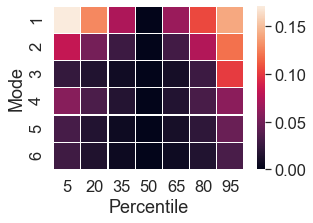

In [58]:
fig,ax = plt.subplots(figsize=(4.5,3))
fig.patch.set_facecolor('white')
ax = sns.heatmap(mode_theta,annot=False, fmt='.2f', linewidths=.2, vmin = 0, xticklabels=range_modes.astype(np.int), yticklabels=np.arange(n_modes)+1, square=True)
ax.set_ylabel('Mode', fontsize=18)
ax.set_xlabel('Percentile', fontsize=18)
#ax.set_title(r'$\theta')
#ax.set_xticks((np.arange(mode_theta.shape[1])+.5)[::2])
#plt.show()
plt.savefig('Fig2D.pdf', transparent=True)

### This next section examines the sensitivity with the objective function as written in Villongco et al. 2014.  This does NOT result in the mean having a value of zero

Text(0.5, 43.5, 'Z Score')

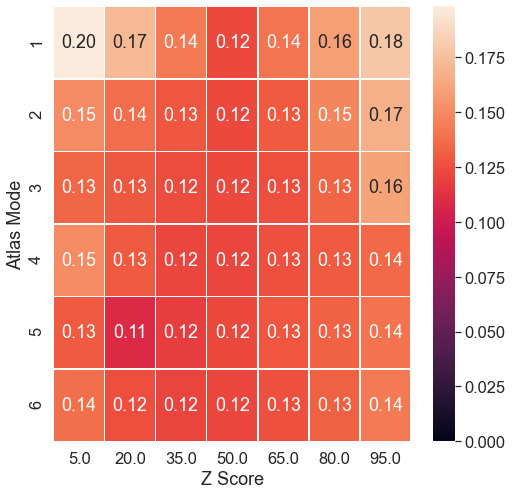

In [37]:
fig,ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax = sns.heatmap(mode_theta_wrong,annot=True, fmt='.2f',  linewidths=.5, vmin = 0, xticklabels=range_modes, yticklabels=np.arange(n_modes)+1)
ax.set_ylabel('Atlas Mode', fontsize=18)
ax.set_xlabel('Z Score', fontsize=18)

In [38]:
mode_theta_wrong_shift = mode_theta_wrong - np.min(mode_theta_wrong)

Text(0.5, 43.5, 'Z Score')

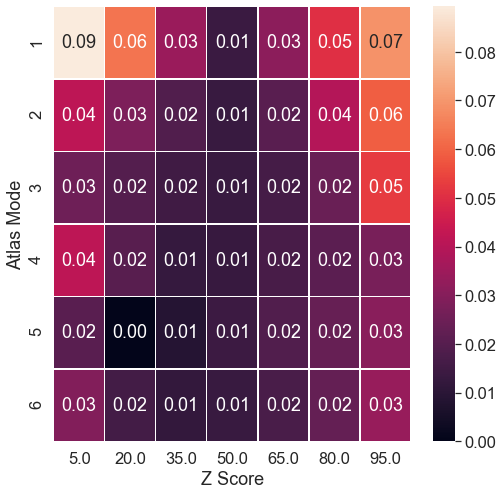

In [39]:
fig,ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax = sns.heatmap(mode_theta_wrong_shift, annot=True, fmt='.2f', linewidths=.5, vmin = 0, xticklabels=range_modes, yticklabels=np.arange(n_modes)+1)
ax.set_ylabel('Atlas Mode', fontsize=18)
ax.set_xlabel('Z Score', fontsize=18)

## RMS Error 

Text(0.5, 43.5, 'Z Score')

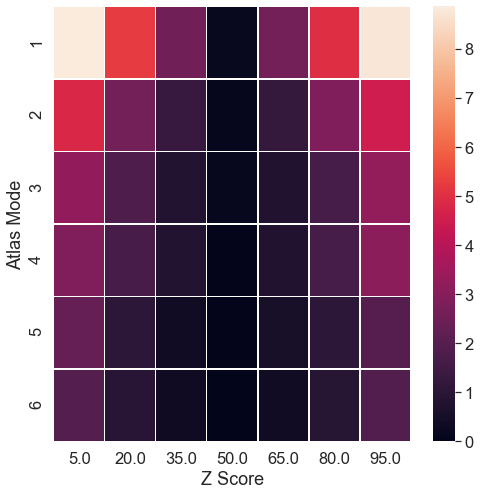

In [40]:
fig,ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax = sns.heatmap(mode_rms,annot=False, fmt='.2f', linewidths=.5, vmin = 0, xticklabels=range_modes, yticklabels=np.arange(n_modes)+1)
ax.set_ylabel('Atlas Mode', fontsize=18)
ax.set_xlabel('Z Score', fontsize=18)

## RMS Error after normalizing magnatude

Text(0.5, 43.5, 'Z Score')

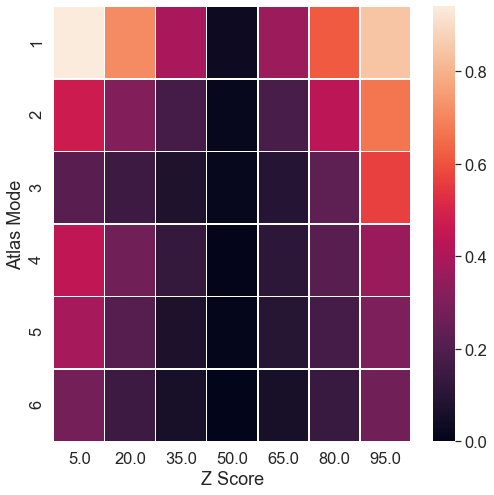

In [41]:
fig,ax = plt.subplots(figsize=(8,8))
fig.patch.set_facecolor('white')
ax = sns.heatmap(mode_rms_norm,annot=False, fmt='.2f', linewidths=.5, vmin = 0, xticklabels=range_modes, yticklabels=np.arange(n_modes)+1)
ax.set_ylabel('Atlas Mode', fontsize=18)
ax.set_xlabel('Z Score', fontsize=18)

# RMS by component

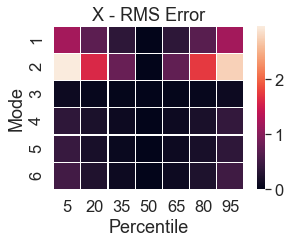

In [53]:
fig,ax = plt.subplots(figsize=(4.5,3))
fig.patch.set_facecolor('white')
ax = sns.heatmap(mode_rmsx,annot=False, fmt='.2f', linewidths=.2, vmin = 0, xticklabels=range_modes.astype(np.int), yticklabels=np.arange(n_modes)+1, square=True)
ax.set_ylabel('Mode', fontsize=18)
ax.set_xlabel('Percentile', fontsize=18)
ax.set_title('X - RMS Error')
#ax.set_xticks((np.arange(mode_theta.shape[1])+.5)[::2])
#plt.show()
plt.savefig('Fig2E-X.pdf', transparent=True)

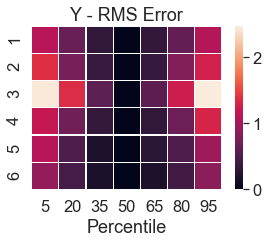

In [54]:
fig,ax = plt.subplots(figsize=(4.5,3))
fig.patch.set_facecolor('white')
ax = sns.heatmap(mode_rmsy,annot=False, fmt='.2f', linewidths=.2, vmin = 0, xticklabels=range_modes.astype(np.int), yticklabels=np.arange(n_modes)+1, square=True)
#ax.set_ylabel('Atlas Mode', fontsize=18)
ax.set_xlabel('Percentile', fontsize=18)
ax.set_title('Y - RMS Error')
#ax.set_xticks((np.arange(mode_theta.shape[1])+.5)[::2])
#plt.show()
plt.savefig('Fig2E-Y.pdf', transparent=True)

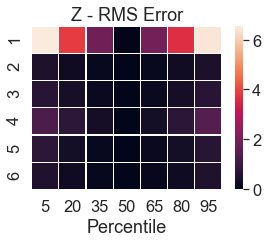

In [55]:
fig,ax = plt.subplots(figsize=(4.5,3))
fig.patch.set_facecolor('white')
ax = sns.heatmap(mode_rmsz,annot=False, fmt='.2f', linewidths=.2, vmin = 0, xticklabels=range_modes.astype(np.int), yticklabels=np.arange(n_modes)+1, square=True)
#ax.set_ylabel('Atlas Mode', fontsize=18)
ax.set_xlabel('Percentile', fontsize=18)
ax.set_title('Z - RMS Error')
#ax.set_xticks((np.arange(mode_theta.shape[1])+.5)[::2])
#plt.show()
plt.savefig('Fig2E-Z.pdf', transparent=True)